# **Buenos_Aires_Real_Estate: Predicting Price with Size, Location, and Neighborhood**

In [69]:
# Imported libraries
import glob
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

## **Import data**

### **Task 2.1.1: Write a function named wrangle that takes a file path as an argument and returns a DataFrame.**

In [70]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features with high NAN
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop the low and high cardility categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=['price',
                     'price_aprox_local_currency',
                     'price_per_m2',
                     'price_usd_per_m2'], 
            inplace = True)
    
    # Drop columns with multicollinearlity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace = True)
    return df

### **Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the directory. Assign this list to the variable name files**

In [71]:
files = glob.glob("buenos-aires-real-estate-*.csv")
files

['buenos-aires-real-estate-4.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-5.csv',
 'buenos-aires-real-estate-3.csv']

### **Use your wrangle function in a for loop to create a list named frames. The list should the cleaned DataFrames created from the CSV filenames your collected in files.**


In [72]:
frames = []

for file in files:
    df = wrangle(file)
    #print(df.shape)
    frames.append(df)

### **Use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True**

In [73]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,59000.0,40.0,-34.604069,-58.460209,Paternal
1,78900.0,38.0,-34.620026,-58.388467,Congreso
2,240000.0,88.0,-34.599857,-58.489002,Agronomía
3,75000.0,34.0,-34.612338,-58.401328,Balvanera
4,110000.0,46.0,-34.586160,-58.475633,Parque Chas


## **Explore**

### **Calculate the number of unique values for each non-numeric feature in df**

In [74]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

### **Plot a correlation heatmap of the remaining numerical features in df. Since "price_aprox_usd" will be your target, you don't need to include it in your heatmap.**

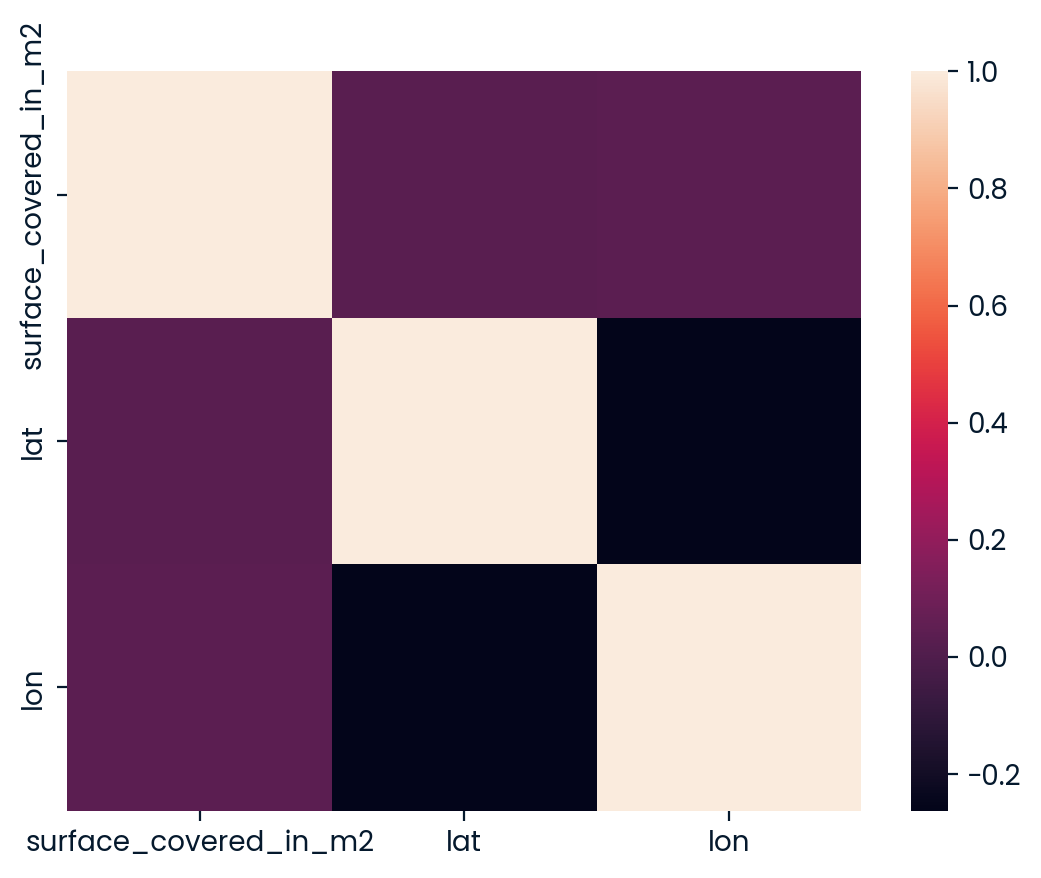

In [75]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

## **Split**

### **Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above..**

In [76]:
target = "price_aprox_usd"
feature = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train = df[feature]
y_train= df[target]

## **Build Model**

### **Baseline**
### **Calculate the baseline mean absolute error for your model.**

In [77]:
y_mean = y_train.mean().round(2)
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

MAE = mean_absolute_error(y_train, y_pred_baseline).round(2)
print("Baseline MAE:", MAE)

Mean apt price: 132383.84
Baseline MAE: 44860.11


## **Iterate**

### **Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.**

In [78]:
model = make_pipeline(OneHotEncoder(handle_unknown='ignore'), 
                      SimpleImputer(), 
                      Ridge()
                     )
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## **Evaluate**

### **Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.**

In [79]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 9572.54


In [80]:
#X_test = df[features]
#y_pred_test = pd.Series(model.predict(X_test))
#y_pred_test.head()

# Generate predictions using a trained model in scikit-learn.
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([ 66963.34382884,  75395.90445248, 228879.7710184 ,  69391.66555667,
       105903.64315043])

## **Communicate Results**

### **Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.**

In [81]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
            "surface_covered_in_m2":[area], 
            "lat":[lat], 
            "lon":[lon], 
            "neighborhood":[neighborhood]
            }
    df = pd.DataFrame(data)
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

# Now calling the function with the correct format
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $127913.33'

### **Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.**

In [82]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

'Predicted apartment price: $109989.64'

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…